# 03 - Hierarchy Analysis

This notebook:
1. Loads trained MSAE models
2. Computes hierarchy metrics:
   - **Nestedness**: Are k=16 features a subset of k=32 features?
   - **Reconstruction gap**: R²(k=128) - R²(k=16)
   - **Feature stability**: Which features appear at multiple k levels?
   - **Feature importance by k**: Which k level activates each feature most?
3. **Extracts SAE features** for downstream analysis (NB04, NB05)
4. Saves results to `outputs/results/hierarchy.json`

## Setup

In [1]:
# ============================================================================
# COLAB SETUP - Run this cell first!
# ============================================================================
import sys
from pathlib import Path

# Detect if running in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab")

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Set up paths
    DRIVE_ROOT = Path('/content/drive/MyDrive/chaos')
    DRIVE_ROOT.mkdir(parents=True, exist_ok=True)

    print(f"Drive mounted. Project root: {DRIVE_ROOT}")
else:
    print("Running locally")
    DRIVE_ROOT = None

Running in Google Colab
Mounted at /content/drive
Drive mounted. Project root: /content/drive/MyDrive/chaos


In [2]:
# ============================================================================
# COLAB: Install dependencies and upload src.zip
# ============================================================================
if IN_COLAB:
    print("Installing dependencies...")
    !pip install -q torch>=2.0.0 h5py>=3.8.0 sgfmill>=1.1.0
    !pip install -q matplotlib>=3.7.0 tqdm>=4.65.0
    !pip install -q scikit-learn>=1.2.0 scipy>=1.10.0
    print("Dependencies installed!")

    # Unzip src.zip
    !unzip -n -q src.zip -d /content/

Installing dependencies...
Dependencies installed!


In [3]:
import sys
import os

# Add search path for 'src' module
if IN_COLAB:
    sys.path.insert(0, '/content')
sys.path.insert(0, '.')

# Configuration
CONFIG = {
    'output_dir': 'outputs',  # Will be overridden for Colab below

    'block_indices': [5, 20, 35],
    'k_levels': [16, 32, 64, 128],

    # Analysis settings
    'batch_size': 4096,
    'n_samples': 100000,  # Samples to use for analysis
}

# ============================================================================
# COLAB: Configure paths for Drive storage
# ============================================================================
if IN_COLAB:
    CONFIG['output_dir'] = str(DRIVE_ROOT)

    # Ensure output directories exist
    (DRIVE_ROOT / 'data').mkdir(parents=True, exist_ok=True)
    (DRIVE_ROOT / 'data' / 'activations').mkdir(parents=True, exist_ok=True)
    (DRIVE_ROOT / 'data' / 'sae_features').mkdir(parents=True, exist_ok=True)
    (DRIVE_ROOT / 'models').mkdir(parents=True, exist_ok=True)
    (DRIVE_ROOT / 'results').mkdir(parents=True, exist_ok=True)
    (DRIVE_ROOT / 'figures').mkdir(parents=True, exist_ok=True)

    print(f"Output directory: {CONFIG['output_dir']}")

Output directory: /content/drive/MyDrive/chaos


In [4]:
# Verify data is available
from pathlib import Path

print("Checking for required data...")

# Check for models
models_dir = Path(CONFIG['output_dir']) / 'models'
for block_idx in CONFIG['block_indices']:
    model_path = models_dir / f'msae_block{block_idx}.pt'
    if model_path.exists():
        print(f"  Model block {block_idx}: Found")
    else:
        print(f"  Model block {block_idx}: NOT FOUND - run notebook 02 first!")

# Check for activations
activations_dir = Path(CONFIG['output_dir']) / 'data' / 'activations'
for block_idx in CONFIG['block_indices']:
    block_dir = activations_dir / f'block{block_idx}'
    if block_dir.exists() and list(block_dir.glob('chunk_*.npy')):
        print(f"  Activations block {block_idx}: Found")
    else:
        print(f"  Activations block {block_idx}: NOT FOUND - run notebook 01 first!")

Checking for required data...
  Model block 5: Found
  Model block 20: Found
  Model block 35: Found
  Activations block 5: Found
  Activations block 20: Found
  Activations block 35: Found


In [5]:
import torch
import numpy as np
from pathlib import Path
import json

# Device selection
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
        return device
    if torch.backends.mps.is_available():
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        print("Using MPS (Apple Silicon)")
        return torch.device('mps')
    print("Using CPU")
    return torch.device('cpu')

device = get_device()

Using CUDA: Tesla T4


In [6]:
from src.models import MatryoshkaSAE
from src.analysis.hierarchy import (
    analyze_hierarchy,
    save_hierarchy_results,
    print_hierarchy_summary,
    compute_nestedness,
    compute_reconstruction_r2,
    compute_feature_stability,
    compute_feature_importance_by_k,
)
from src.utils import clear_memory

## 1. Load Models and Activations

In [7]:
import h5py

def load_msae(block_idx: int):
    """Load trained MSAE model for a block."""
    model_path = Path(CONFIG['output_dir']) / 'models' / f'msae_block{block_idx}.pt'

    if not model_path.exists():
        print(f"MSAE not found for block {block_idx}")
        return None

    # weights_only=False needed because checkpoint contains numpy arrays (normalization stats)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    config = checkpoint['config']

    model = MatryoshkaSAE(
        input_dim=config['input_dim'],
        hidden_dim=config['hidden_dim'],
        k_levels=config['k_levels'],
        weighting=config.get('weighting', 'uniform'),
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"Loaded MSAE for block {block_idx}")
    print(f"  Input dim: {config['input_dim']}")
    print(f"  Hidden dim: {config['hidden_dim']}")
    print(f"  K levels: {config['k_levels']}")

    return model


def load_activations(block_idx: int, max_samples: int):
    """Load and normalize activations for a block from h5py file."""
    h5_path = Path(CONFIG['output_dir']) / 'data' / 'activations.h5'

    if not h5_path.exists():
        print(f"Activations file not found: {h5_path}")
        return None

    with h5py.File(h5_path, 'r') as f:
        block_key = f'block{block_idx}'

        if block_key not in f:
            print(f"Block {block_idx} not found in {h5_path}")
            return None

        dset = f[block_key]

        # Load activations (limit to max_samples)
        n_samples = min(max_samples, dset.shape[0])
        activations = dset[:n_samples]

        # Load normalization stats from attributes and normalize
        mean = dset.attrs['mean']
        std = dset.attrs['std']
        activations = (activations - mean) / (std + 1e-8)

    print(f"Loaded {len(activations):,} activations for block {block_idx}")

    return activations.astype(np.float32)

## 2. Run Hierarchy Analysis

In [8]:
all_metrics = []

for block_idx in CONFIG['block_indices']:
    layer_name = f'block{block_idx}'
    print(f"\n{'='*60}")
    print(f"Analyzing {layer_name}")
    print(f"{'='*60}")

    # Load model and activations
    model = load_msae(block_idx)
    activations = load_activations(block_idx, CONFIG['n_samples'])

    if model is None or activations is None:
        print(f"Skipping {layer_name}")
        continue

    # Run full analysis
    metrics = analyze_hierarchy(
        model=model,
        activations=activations,
        layer_name=layer_name,
        batch_size=CONFIG['batch_size'],
        device=device,
    )

    # Print summary
    print_hierarchy_summary(metrics)

    all_metrics.append(metrics)

    # Clean up
    del model, activations
    clear_memory(verbose=True)


Analyzing block5
Loaded MSAE for block 5
  Input dim: 256
  Hidden dim: 4096
  K levels: [16, 32, 64, 128]
Loaded 100,000 activations for block 5
Analyzing hierarchy for block5...
  Using 100,000 samples (stability: 10,000)
  Pre-computing encoder outputs...
  Computing nestedness...
  Computing reconstruction R²...
  Computing feature stability...

Hierarchy Analysis: block5

Reconstruction R² by k:
  k= 16: 0.8304
  k= 32: 0.9022
  k= 64: 0.9522
  k=128: 0.9808

Reconstruction gap (k_max - k_min): 0.1504

Nestedness (fraction of lower-k in higher-k):
  k16_in_k32: 1.0000
  k32_in_k64: 1.0000
  k64_in_k128: 1.0000

Feature stability:
  stability_ratio: 1.0000
  total_features_analyzed: 3930
  stable_features: 3930
GPU memory: 0.01GB allocated, 0.02GB cached

Analyzing block20
Loaded MSAE for block 20
  Input dim: 256
  Hidden dim: 4096
  K levels: [16, 32, 64, 128]
Loaded 100,000 activations for block 20
Analyzing hierarchy for block20...
  Using 100,000 samples (stability: 10,000)
 

## 3. Save Results

In [9]:
if all_metrics:
    save_hierarchy_results(all_metrics, CONFIG['output_dir'], 'hierarchy.json')
    print(f"\nSaved results to {Path(CONFIG['output_dir']) / 'results' / 'hierarchy.json'}")

Saved hierarchy results to /content/drive/MyDrive/chaos/results/hierarchy.json

Saved results to /content/drive/MyDrive/chaos/results/hierarchy.json


## 4. Visualize Hierarchy

Saved reconstruction plot to /content/drive/MyDrive/chaos/figures/reconstruction_plot.png


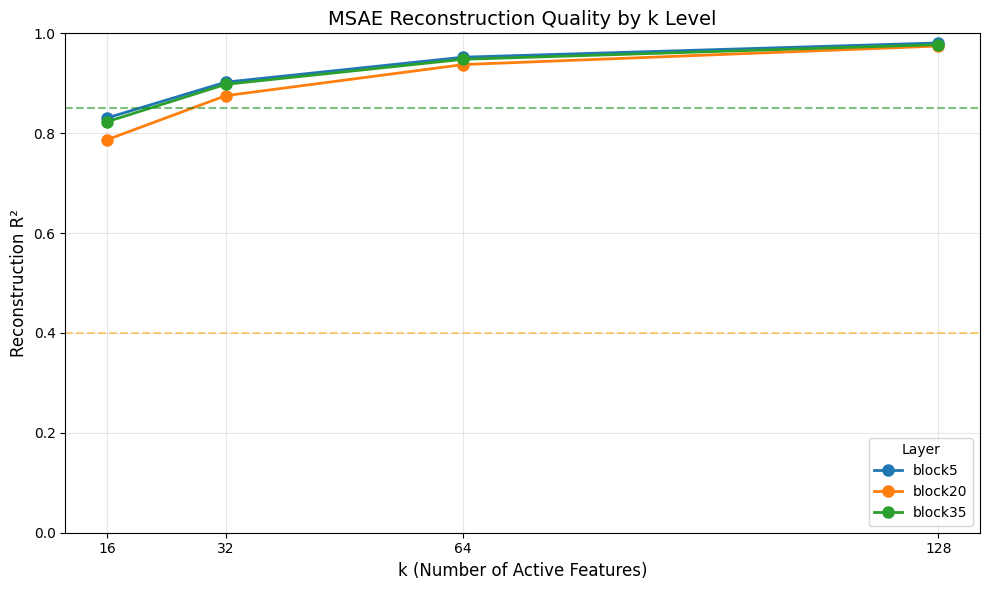

In [10]:
import matplotlib.pyplot as plt
from src.visualization.plots import plot_reconstruction_r2, plot_nestedness_matrix

if all_metrics:
    # Plot R² by k level
    r2_results = {m.layer: m.reconstruction_r2 for m in all_metrics}

    fig = plot_reconstruction_r2(
        results=r2_results,
        k_levels=CONFIG['k_levels'],
        output_path=str(Path(CONFIG['output_dir']) / 'figures' / 'reconstruction_plot.png'),
    )
    plt.show()

Saved nestedness heatmap to /content/drive/MyDrive/chaos/figures/hierarchy_heatmap.png


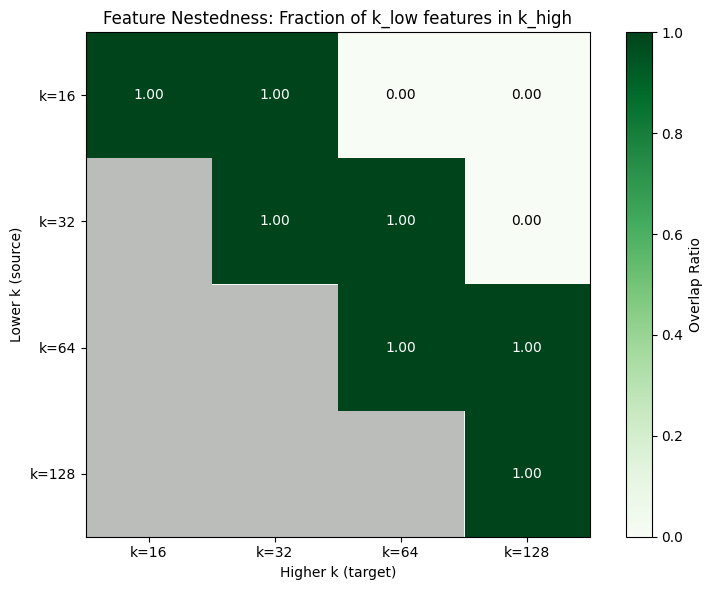

In [11]:
if all_metrics:
    # Plot nestedness matrix for middle layer
    for metrics in all_metrics:
        if metrics.layer == 'block20':
            fig = plot_nestedness_matrix(
                nestedness=metrics.nestedness,
                k_levels=CONFIG['k_levels'],
                output_path=str(Path(CONFIG['output_dir']) / 'figures' / 'hierarchy_heatmap.png'),
            )
            plt.show()
            break

## 5. Feature Importance by K Level

Loaded MSAE for block 20
  Input dim: 256
  Hidden dim: 4096
  K levels: [16, 32, 64, 128]
Loaded 100,000 activations for block 20

Feature importance matrix shape: (4096, 4)
(hidden_dim, n_k_levels) = (4096, 4)


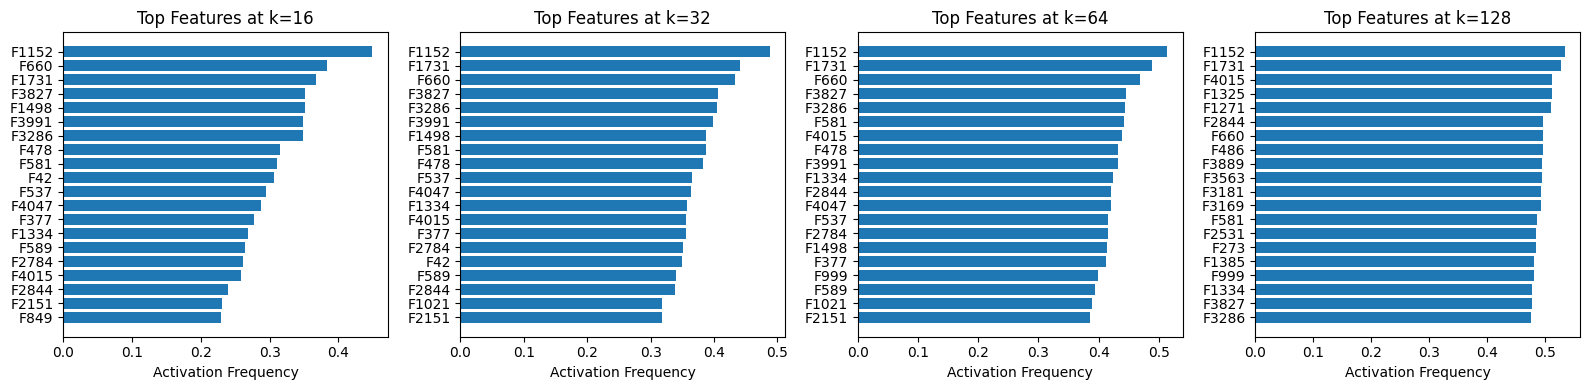

In [12]:
# Load one model for detailed feature analysis
model = load_msae(20)
activations = load_activations(20, CONFIG['n_samples'])

if model is not None and activations is not None:
    act_tensor = torch.from_numpy(activations).to(device)

    # Compute feature importance
    importance_matrix = compute_feature_importance_by_k(
        model, act_tensor, CONFIG['k_levels']
    )

    print(f"\nFeature importance matrix shape: {importance_matrix.shape}")
    print(f"(hidden_dim, n_k_levels) = ({model.hidden_dim}, {len(CONFIG['k_levels'])})")

    # Plot top features at each k
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i, k in enumerate(CONFIG['k_levels']):
        ax = axes[i]
        importance = importance_matrix[:, i]

        # Get top 20 features
        top_indices = np.argsort(importance)[-20:][::-1]

        ax.barh(range(20), importance[top_indices])
        ax.set_yticks(range(20))
        ax.set_yticklabels([f'F{idx}' for idx in top_indices])
        ax.set_xlabel('Activation Frequency')
        ax.set_title(f'Top Features at k={k}')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.savefig(Path(CONFIG['output_dir']) / 'figures' / 'feature_importance_by_k.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    del model, activations
    clear_memory()

## 6. Check Success Criteria

In [13]:
print("\nSuccess Criteria Check:")
print("=" * 60)

if all_metrics:
    for metrics in all_metrics:
        print(f"\n{metrics.layer}:")

        # Check nestedness
        avg_nestedness = np.mean(list(metrics.nestedness.values()))
        print(f"  Avg nestedness: {avg_nestedness:.3f}")
        print(f"    Target: > 0.80 (good Matryoshka structure)")
        print(f"    Status: {'PASS' if avg_nestedness > 0.80 else 'NEEDS IMPROVEMENT'}")

        # Check reconstruction gap
        print(f"  Reconstruction gap: {metrics.reconstruction_gap:.3f}")
        print(f"    Required: > 0.25, Target: > 0.35")
        print(f"    Status: {'PASS' if metrics.reconstruction_gap > 0.25 else 'FAIL'}")

        # Check R² at k=128
        r2_128 = metrics.reconstruction_r2.get(128, 0)
        print(f"  R² at k=128: {r2_128:.3f}")
        print(f"    Required: > 0.85, Target: > 0.92")
        print(f"    Status: {'PASS' if r2_128 > 0.85 else 'FAIL'}")


Success Criteria Check:

block5:
  Avg nestedness: 1.000
    Target: > 0.80 (good Matryoshka structure)
    Status: PASS
  Reconstruction gap: 0.150
    Required: > 0.25, Target: > 0.35
    Status: FAIL
  R² at k=128: 0.981
    Required: > 0.85, Target: > 0.92
    Status: PASS

block20:
  Avg nestedness: 1.000
    Target: > 0.80 (good Matryoshka structure)
    Status: PASS
  Reconstruction gap: 0.188
    Required: > 0.25, Target: > 0.35
    Status: FAIL
  R² at k=128: 0.975
    Required: > 0.85, Target: > 0.92
    Status: PASS

block35:
  Avg nestedness: 1.000
    Target: > 0.80 (good Matryoshka structure)
    Status: PASS
  Reconstruction gap: 0.155
    Required: > 0.25, Target: > 0.35
    Status: FAIL
  R² at k=128: 0.977
    Required: > 0.85, Target: > 0.92
    Status: PASS


## 7. Extract SAE Features for Downstream Analysis

Extract full 4096-D SAE encoder outputs for use in notebooks 05+ (attractor basins, topology).

**Output**: `outputs/data/sae_features/block{5,20,35}_features.npy` — shape `[n_positions, 4096]`

In [14]:
from tqdm import tqdm
from typing import Tuple
from src.utils.system import get_system_capabilities

def extract_sae_features_streaming(
    block_idx: int,
    output_h5_path: Path,
    batch_size: int = None,
    chunk_size: int = 10000,
) -> Tuple[int, int]:
    """
    Extract SAE features using streaming - memory efficient.

    Streams through activations.h5 in chunks, processes through SAE,
    and saves to output h5py file. Never loads all data into memory.

    Args:
        block_idx: Block index (5, 20, or 35)
        output_h5_path: Path to save SAE features (h5py format)
        batch_size: GPU batch size (auto-detected if None)
        chunk_size: Chunk size for h5py streaming

    Returns:
        (n_samples, n_features) tuple
    """
    print(f"\nExtracting SAE features for block {block_idx} (streaming)...")

    # Auto-detect optimal batch size
    if batch_size is None:
        caps = get_system_capabilities()
        batch_size = caps.optimal_batch_size(base_batch_size=4096)
        print(f"  GPU batch size: {batch_size} (auto-detected)")

    # Load model
    model_path = Path(CONFIG['output_dir']) / 'models' / f'msae_block{block_idx}.pt'
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    config = checkpoint['config']
    norm_stats = checkpoint.get('normalization', {})

    model = MatryoshkaSAE(
        input_dim=config['input_dim'],
        hidden_dim=config['hidden_dim'],
        k_levels=config['k_levels'],
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Get normalization stats
    mean = torch.from_numpy(norm_stats['mean']).float().to(device)
    std = torch.from_numpy(norm_stats['std']).float().to(device)

    # Paths
    h5_input_path = Path(CONFIG['output_dir']) / 'data' / 'activations.h5'
    hidden_dim = config['hidden_dim']

    with h5py.File(h5_input_path, 'r') as f_in:
        dset_in = f_in[f'block{block_idx}']
        n_samples, input_dim = dset_in.shape

        print(f"  Input: {n_samples:,} samples × {input_dim} dims")
        print(f"  Output: {n_samples:,} samples × {hidden_dim} dims")
        print(f"  Memory saved: {n_samples * hidden_dim * 4 / 1e9:.2f} GB (not in RAM)")

        with h5py.File(output_h5_path, 'w') as f_out:
            # Create output dataset with chunking
            dset_out = f_out.create_dataset(
                f'block{block_idx}',
                shape=(n_samples, hidden_dim),
                dtype=np.float32,
                chunks=(min(chunk_size, n_samples), hidden_dim),
                compression='gzip',
                compression_opts=4,
            )

            # Store metadata as attributes
            dset_out.attrs['block_idx'] = block_idx
            dset_out.attrs['hidden_dim'] = hidden_dim
            dset_out.attrs['input_dim'] = input_dim

            # Process in chunks
            for start in tqdm(range(0, n_samples, chunk_size), desc=f"Block {block_idx}"):
                end = min(start + chunk_size, n_samples)
                chunk = dset_in[start:end]

                # Convert to tensor and normalize
                chunk_tensor = torch.from_numpy(chunk).float().to(device)
                chunk_norm = (chunk_tensor - mean) / (std + 1e-8)

                # Process in GPU batches within chunk
                chunk_features = []
                for batch_start in range(0, len(chunk_norm), batch_size):
                    batch_end = min(batch_start + batch_size, len(chunk_norm))
                    batch = chunk_norm[batch_start:batch_end]

                    with torch.no_grad():
                        z = model.encode(batch)

                    chunk_features.append(z.cpu().numpy())

                # Write chunk to output
                features = np.concatenate(chunk_features, axis=0)
                dset_out[start:end] = features

    print(f"  Saved: {output_h5_path}")
    print(f"  File size: {output_h5_path.stat().st_size / 1e9:.2f} GB")

    # Clean up
    del model
    clear_memory(verbose=False)

    return n_samples, hidden_dim


# Create output directory
sae_features_dir = Path(CONFIG['output_dir']) / 'data' / 'sae_features'
sae_features_dir.mkdir(parents=True, exist_ok=True)

# Extract and save for each block using streaming
for block_idx in CONFIG['block_indices']:
    output_path = sae_features_dir / f'block{block_idx}_features.h5'

    n_samples, n_features = extract_sae_features_streaming(
        block_idx=block_idx,
        output_h5_path=output_path,
        batch_size=CONFIG.get('batch_size'),
    )

    clear_memory(verbose=True)

print(f"\nSAE features saved to {sae_features_dir}")
print("Files are in h5py format for memory-efficient streaming.")


Extracting SAE features for block 5 (streaming)...
  Input: 495,995 samples × 256 dims
  Output: 495,995 samples × 4096 dims
  Memory saved: 8.13 GB (not in RAM)


Block 5: 100%|██████████| 50/50 [01:31<00:00,  1.82s/it]


  Saved: /content/drive/MyDrive/chaos/data/sae_features/block5_features.h5
  File size: 0.73 GB
GPU memory: 0.11GB allocated, 0.12GB cached

Extracting SAE features for block 20 (streaming)...
  Input: 495,995 samples × 256 dims
  Output: 495,995 samples × 4096 dims
  Memory saved: 8.13 GB (not in RAM)


Block 20: 100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


  Saved: /content/drive/MyDrive/chaos/data/sae_features/block20_features.h5
  File size: 0.80 GB
GPU memory: 0.11GB allocated, 0.12GB cached

Extracting SAE features for block 35 (streaming)...
  Input: 495,995 samples × 256 dims
  Output: 495,995 samples × 4096 dims
  Memory saved: 8.13 GB (not in RAM)


Block 35: 100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


  Saved: /content/drive/MyDrive/chaos/data/sae_features/block35_features.h5
  File size: 0.74 GB
GPU memory: 0.11GB allocated, 0.12GB cached

SAE features saved to /content/drive/MyDrive/chaos/data/sae_features
Files are in h5py format for memory-efficient streaming.


In [ ]:
# Download Analysis Artifacts
from google.colab import files
from pathlib import Path
import shutil

# Define artifacts to download
artifacts = [
    # Results
    Path(CONFIG['output_dir']) / 'results' / 'hierarchy.json',

    # Figures
    Path(CONFIG['output_dir']) / 'figures' / 'reconstruction_plot.png',
    Path(CONFIG['output_dir']) / 'figures' / 'hierarchy_heatmap.png',
    Path(CONFIG['output_dir']) / 'figures' / 'feature_importance_by_k.png',
]

# Create zip archive
zip_name = 'notebook06_hierarchy_artifacts'
zip_path = Path(CONFIG['output_dir']) / zip_name

# Collect existing files
files_to_zip = [f for f in artifacts if f.exists()]
print(f"Packaging {len(files_to_zip)} artifacts...")

# Create temp directory and copy files
temp_dir = Path('/tmp') / zip_name
temp_dir.mkdir(exist_ok=True)

for f in files_to_zip:
    dest = temp_dir / f.name
    shutil.copy(f, dest)
    print(f"  ✓ {f.name}")

# Create zip
shutil.make_archive(str(zip_path), 'zip', temp_dir)
print(f"\nCreated: {zip_path}.zip")

# Download
files.download(f"{zip_path}.zip")

# Cleanup
shutil.rmtree(temp_dir)

## Summary

Results saved to:
- `outputs/results/hierarchy.json`
- `outputs/data/sae_features/block{5,20,35}_features.npy` - SAE encoder outputs for downstream analysis

Figures saved to:
- `outputs/figures/reconstruction_plot.png`
- `outputs/figures/hierarchy_heatmap.png`
- `outputs/figures/feature_importance_by_k.png`

## Next Steps

1. **04_pca_baseline.ipynb**: Compare PCA vs SAE representations
2. **05_attractor_basins.ipynb**: TICA → HDBSCAN → MSM analysis